# Weight datasets

In [1]:
%pwd

'/net/tscratch/people/plgkingak'

In [2]:
path = "weights2weights/weights_datasets"
device = "cuda"

In [3]:
import torch
import numpy as np
import pandas as pd
from datasets import Dataset, concatenate_datasets

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
weight_dimensions = torch.load(f"{path}/weight_dimensions.pt")

In [6]:
dim_df = pd.DataFrame(weight_dimensions).T

In [7]:
dim_df

,0,1
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.weight,"(320,)","(1, 320)"
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.weight,"(320,)","(320, 1)"
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.weight,"(320,)","(1, 320)"
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.weight,"(320,)","(320, 1)"
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q.lora_A.weight,"(320,)","(1, 320)"
...,...,...
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn1.to_v.lora_B.weight,"(320,)","(320, 1)"
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_q.lora_A.weight,"(320,)","(1, 320)"
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_q.lora_B.weight,"(320,)","(320, 1)"
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_v.lora_A.weight,"(768,)","(1, 768)"


## Mid block

In [8]:
dim_df["use"] = 0
dim_df.loc[dim_df.index.str.contains("mid_block"), "use"] = 1

In [9]:
dim_df.use.sum()

8

In [10]:
dim_df["lengths"] = [a.numel() for a,_ in list(weight_dimensions.values())]

In [11]:
dim_df["start"] = dim_df.lengths.cumsum().shift(fill_value=0)
dim_df["end"] = dim_df.start + dim_df.lengths

In [12]:
dim_df[dim_df.use == 1]

,0,1,use,lengths,start,end
base_model.model.mid_block.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.weight,"(1280,)","(1, 1280)",1,1280,35968,37248
base_model.model.mid_block.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.weight,"(1280,)","(1280, 1)",1,1280,37248,38528
base_model.model.mid_block.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.weight,"(1280,)","(1, 1280)",1,1280,38528,39808
base_model.model.mid_block.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.weight,"(1280,)","(1280, 1)",1,1280,39808,41088
base_model.model.mid_block.attentions.0.transformer_blocks.0.attn2.to_q.lora_A.weight,"(1280,)","(1, 1280)",1,1280,41088,42368
base_model.model.mid_block.attentions.0.transformer_blocks.0.attn2.to_q.lora_B.weight,"(1280,)","(1280, 1)",1,1280,42368,43648
base_model.model.mid_block.attentions.0.transformer_blocks.0.attn2.to_v.lora_A.weight,"(768,)","(1, 768)",1,768,43648,44416
base_model.model.mid_block.attentions.0.transformer_blocks.0.attn2.to_v.lora_B.weight,"(1280,)","(1280, 1)",1,1280,44416,45696


In [13]:
indices = np.concatenate([np.arange(row.start, row.end) for _, row in dim_df[dim_df.use == 1].iterrows()])
len(indices)


9728

### Save

In [4]:
weights = torch.load(f"{path}/identities/all_weights.pt", torch.device(device))

In [ ]:
torch.save(weights[:,indices], f'{path}/mid_block.pt')

In [4]:
dataset = torch.load(f'{path}/mid_block.pt', torch.device(device))

In [ ]:
Dataset.from_dict({"data":dataset}).save_to_disk(f'{path}/mid_block')

In [8]:
d = Dataset.from_dict({"data":dataset})

In [ ]:
d

In [ ]:
len(d[0]["data"])

## Evaluation samples

In [ ]:
weights = torch.load(f"{path}/identities/all_weights.pt", torch.device(device))

In [8]:
random_indices = torch.randperm(weights.size(0))[:10]
sampled_rows = weights[random_indices]

torch.save(sampled_rows, f'{path}/evaluation_samples.pt')

## Blondes (and brunettes)

In [26]:
import torch
df = torch.load('/net/tscratch/people/plgkingak/weights2weights/files/identity_df.pt')

In [27]:
df.reset_index(inplace=True)

In [28]:
blondes = df.loc[df["Blond_Hair"] == 1]
brunettes = df.loc[df["Black_Hair"] == 1]

In [ ]:
blondes.sample(n=2000, random_state=42)
brunettes.sample(n=2000, random_state=42)

In [23]:
weights = torch.load(f"{path}/identities/all_weights.pt", torch.device(device))

In [ ]:
blonde_weights = weights[blondes.sample(n=2000, random_state=42).index]
blonde_weights.shape

In [34]:
torch.save(blonde_weights.clone(), f"{path}/blondes.pt")

In [ ]:
brunette_weights = weights[brunettes.sample(n=2000, random_state=42).index]
brunette_weights.shape

In [36]:
torch.save(brunette_weights.clone(), f"{path}/brunettes.pt")

## Split

In [8]:
import torch
df = torch.load('/net/tscratch/people/plgkingak/weights2weights/files/identity_df.pt')

In [9]:
weights = torch.load(f"{path}/identities/all_weights.pt", torch.device(device))

In [60]:
filenames = df.index.str.split(".").str[0].to_list()

In [11]:
name = "single"

In [12]:
weights.shape

torch.Size([64974, 99648])

### Check values

Maybe some columns are all 0, or all the same value?

In [10]:
weights.element_size() * weights.nelement() // 1_000_000_000

25

In [13]:
num_rows, num_cols = weights.shape
chunk_size = 512
variance = torch.empty(num_cols, device="cuda", dtype=torch.float16)  # Store results

for start in range(0, num_cols, chunk_size):
    end = min(start + chunk_size, num_cols)
    chunk = weights[:, start:end]  # Load only a subset of columns
    
    mean = chunk.mean(dim=0, keepdim=True)  # Compute mean per column
    var_chunk = ((chunk - mean) ** 2).mean(dim=0)  # Compute variance for chunk
    
    variance[start:end] = var_chunk  # Store results

In [14]:
variance.element_size() * variance.nelement() // 1_000

199

In [19]:
mean = weights.mean(dim=0, keepdim=True)

In [20]:
mean.element_size() * mean.nelement() // 1_000

398

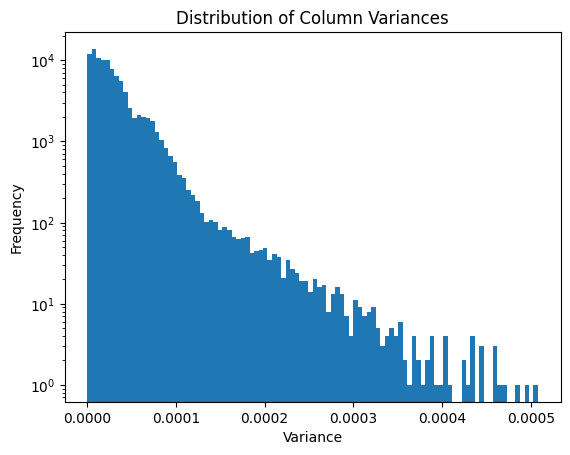

In [21]:
variance_cpu = variance.cpu().numpy()  # Move to CPU for plotting

plt.hist(variance_cpu, bins=100, log=True)  # Log scale to highlight small values
plt.xlabel("Variance")
plt.ylabel("Frequency")
# plt.xscale("log")
plt.title("Distribution of Column Variances")
plt.show()

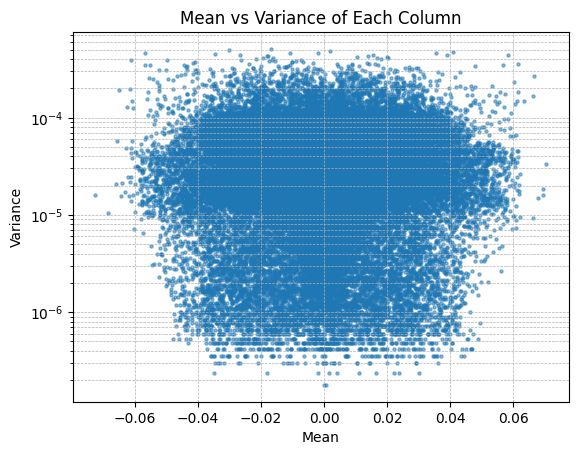

In [28]:
mean_cpu = mean.flatten().cpu().numpy()


plt.scatter(mean_cpu, variance_cpu, alpha=0.5, s=5)  # s=5 makes points small
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Mean vs Variance of Each Column")
# plt.xscale("log")  # Use log scale if necessary
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

In [37]:
min_idx = torch.argmin(variance)

In [56]:
variance[min_idx], mean_cpu[min_idx]

(tensor(1.7881e-07, device='cuda:0', dtype=torch.float16), 9.270384e-05)

In [55]:
torch.finfo(torch.float32).eps

1.1920928955078125e-07

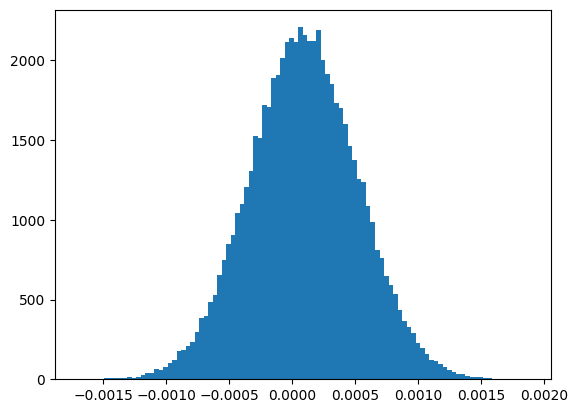

In [57]:
col = weights[:, min_idx].cpu().numpy()
plt.hist(col, bins=100)
plt.show()

In [31]:
mean.flatten().shape

torch.Size([99648])

In [32]:
path

'weights2weights/weights_datasets'

In [35]:
torch.save(mean.flatten(), f"{path}/mean.pt")
torch.save(variance, f"{path}/variance.pt")

### Variance in blocks

In [11]:
weights.shape

torch.Size([64974, 99648])

In [ ]:
dim_df.reset_index(inplace=True)
dim_df["key"] = dim_df["index"].apply(lambda x: ".".join(x.split(".")[:4]))
dim_df["length"] = dim_df[0].str[0]
dim_df.groupby("key").sum()["length"]

In [54]:
group_sizes = dim_df.groupby("key").sum()["length"].to_dict()

In [ ]:
mean_dict = {}
variance_dict = {}
chunk_size = 512

start_idx = 0  # Track column index
for group_name, group_size in group_sizes.items():
    end_idx = start_idx + group_size  # End index for the group
    
    mean_values = torch.empty(group_size, device="cuda", dtype=torch.float16)  # Store mean per column
    variance_values = torch.empty(group_size, device="cuda", dtype=torch.float16)  # Store variance per column

    chunk_idx = 0  # Track position within group
    for chunk_start in range(start_idx, end_idx, chunk_size):
        chunk_end = min(chunk_start + chunk_size, end_idx)
        chunk = weights[:, chunk_start:chunk_end]  # Extract chunk (subset of columns)
        
        # Compute mean and variance per column in the chunk
        mean_chunk = chunk.mean(dim=0)  # Mean per column
        var_chunk = chunk.var(dim=0, unbiased=False)  # Variance per column (efficient)

        # Store results in allocated tensors
        mean_values[chunk_idx:chunk_idx + mean_chunk.shape[0]] = mean_chunk
        variance_values[chunk_idx:chunk_idx + var_chunk.shape[0]] = var_chunk

        chunk_idx += mean_chunk.shape[0]  # Move index forward

    # Save results for the group
    mean_dict[group_name] = mean_values
    variance_dict[group_name] = variance_values

    # Update start index for next group
    start_idx = end_idx  

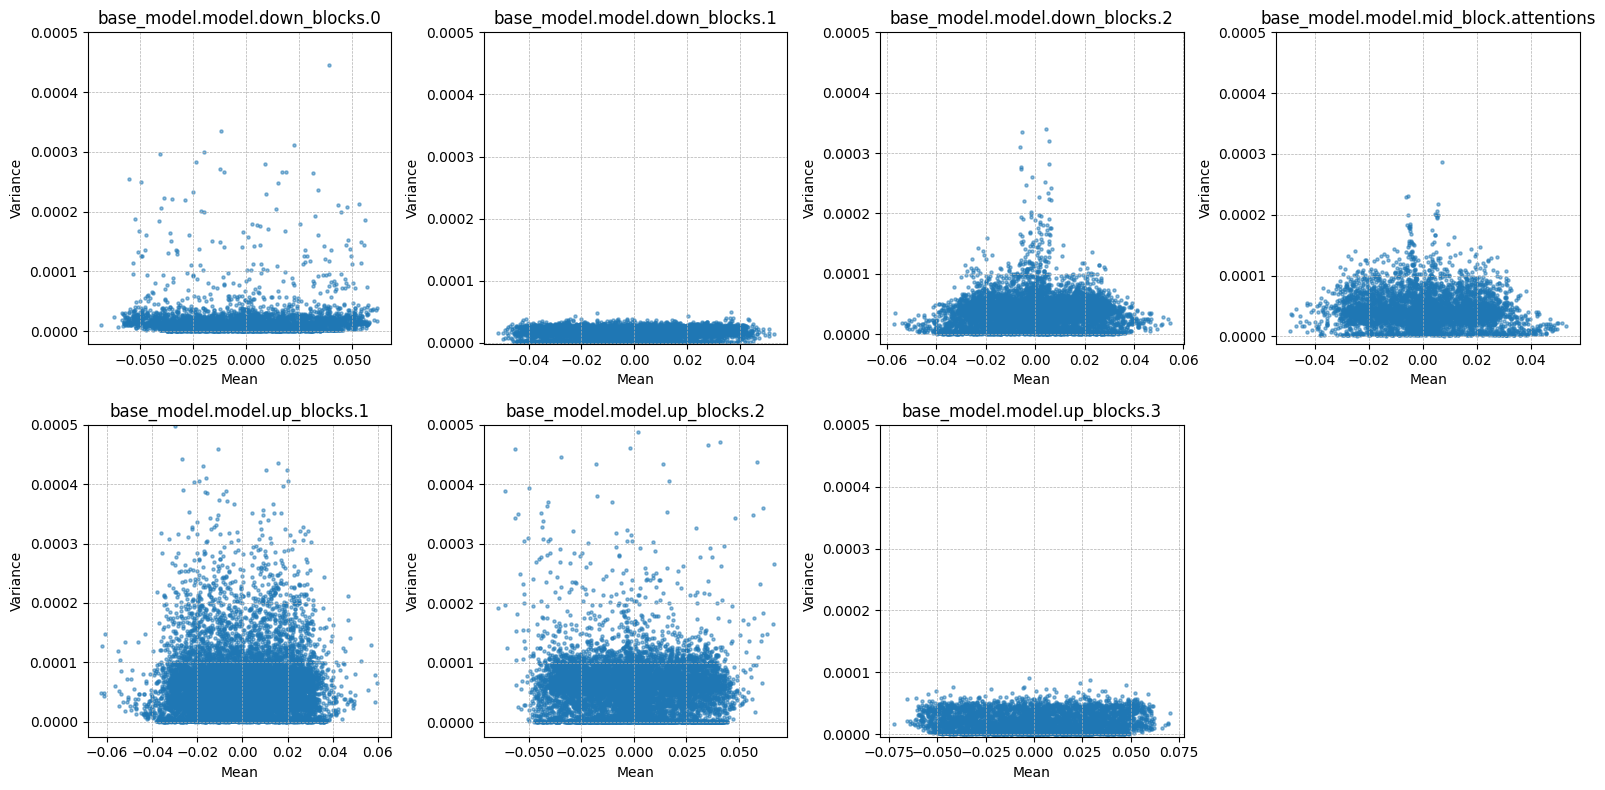

In [73]:
# Set up the figure and axes for a 2x4 grid (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to index

# Loop through the groups and plot each one in the corresponding subplot
for idx, group_name in enumerate(mean_dict.keys()):
    # Get the axis for the current plot
    ax = axes[idx]
    
    # Move data to CPU for plotting
    mean_cpu = mean_dict[group_name].cpu().numpy()
    variance_cpu = variance_dict[group_name].cpu().numpy()

    # Create scatter plot
    ax.scatter(mean_cpu, variance_cpu, alpha=0.5, s=5)  # Small points for clarity
    ax.set_xlabel("Mean")
    ax.set_ylabel("Variance")
    ax.set_title(f"{group_name}")  # Title per group

    # Set y-axis to log scale
    # ax.set_yscale("log")
    
    # Set the y-axis limit for the log scale
    ax.set_ylim(top=5e-4)
    
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# If there are fewer than 8 groups, hide empty subplots
for i in range(len(mean_dict.keys()), 8):
    axes[i].axis('off')  # Hide any remaining empty subplots

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

### Norms in blocks

In [10]:
dim_df

,0,1
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.weight,"(320,)","(1, 320)"
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.weight,"(320,)","(320, 1)"
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.weight,"(320,)","(1, 320)"
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.weight,"(320,)","(320, 1)"
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q.lora_A.weight,"(320,)","(1, 320)"
...,...,...
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn1.to_v.lora_B.weight,"(320,)","(320, 1)"
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_q.lora_A.weight,"(320,)","(1, 320)"
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_q.lora_B.weight,"(320,)","(320, 1)"
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_v.lora_A.weight,"(768,)","(1, 768)"


In [11]:
dim_df["lengths"] = [a.numel() for a,_ in list(weight_dimensions.values())]
dim_df["start"] = dim_df.lengths.cumsum().shift(fill_value=0)
dim_df["end"] = dim_df.start + dim_df.lengths
# dim_df
dim_df["block_type"] = dim_df.index.str.extract(r"(down_blocks|up_blocks)")[0].fillna("mid_block").values
dim_df["block_number"] = dim_df.index.str.extract(r"(?:down_blocks|up_blocks)\.(\d+)")[0].fillna("0").values
dim_df["attentions_number"] = dim_df.index.str.extract(r"attentions\.(\d+)")[0].values
dim_df["attn_number"] = dim_df.index.str.extract(r"attn(\d+)")[0].values
dim_df["attn_proj"] = dim_df.index.str.extract(r"attn\d+\.(to_[qvkout]+)")[0].values
dim_df["lora_ab"] = dim_df.index.str.extract(r"lora_([AB])")[0].values

In [12]:
weights.shape

torch.Size([64974, 99648])

In [45]:
indices = torch.randperm(weights.size(0))[:10000]
weights_sample = weights[indices].clone()

In [46]:
mean = weights.mean(dim=0, keepdim=True)
std = weights.std(dim=0, keepdim=True)
# mean, std
weights_sample.sub_(mean).div_(std) 

tensor([[ 1.0823, -1.8207, -0.3347,  ..., -1.5519, -0.2763,  0.5801],
        [ 0.1942,  0.1715,  0.1057,  ...,  0.8940, -0.2802,  0.2649],
        [-0.4492, -0.7218,  0.5983,  ...,  0.5142, -0.6427,  1.1965],
        ...,
        [-0.4741,  0.1312,  0.7291,  ...,  0.2015, -1.7331, -1.0730],
        [-1.5899, -0.7885, -1.0898,  ..., -0.2442,  0.8084, -0.3817],
        [-0.2472, -0.6969, -0.4217,  ..., -0.8097,  0.5883, -0.9362]],
       device='cuda:0')

In [47]:
def get_group_indices(df, group_columns):
    df = df.sort_values(by=group_columns + ["start"])
    group_indices = {}
    for group_vals, group_df in df.groupby(group_columns):
        group_name = ".".join(map(str, group_vals))  # Example: "attn_proj.lora_ab"
        indices = [(row['start'], row['end']) for _, row in group_df.iterrows()]
        group_indices[group_name] = indices
    return group_indices

In [48]:
def get_heatmap_grouped(group_indices):
    group_norms = []
    group_names = []
    for n, indices in group_indices.items():
        group_subvectors = []
        
        for start, end in indices:
            group_subvectors.append(weights_sample[:, start:end])

        concatenated_group = torch.cat(group_subvectors, dim=1)
        group_norm = concatenated_group.norm(dim=1)/(concatenated_group.shape[1] ** 0.5)
        group_norms.append(group_norm)
        group_names.append(n)

    group_norms = torch.stack(group_norms, dim=1).cpu().detach().numpy()
    plt.figure(figsize=(10, 6))
    sns.heatmap(group_norms,
                 cmap='viridis',
                #  norm=LogNorm(vmin=group_norms.min(), vmax=group_norms.max()),
                 xticklabels=group_names, cbar_kws={'label': 'Norm Value'})
    plt.yticks([])
    plt.title('Norms Heatmap')
    plt.xlabel('LoRA Group')
    plt.ylabel('Sample LoRA')
    plt.show()

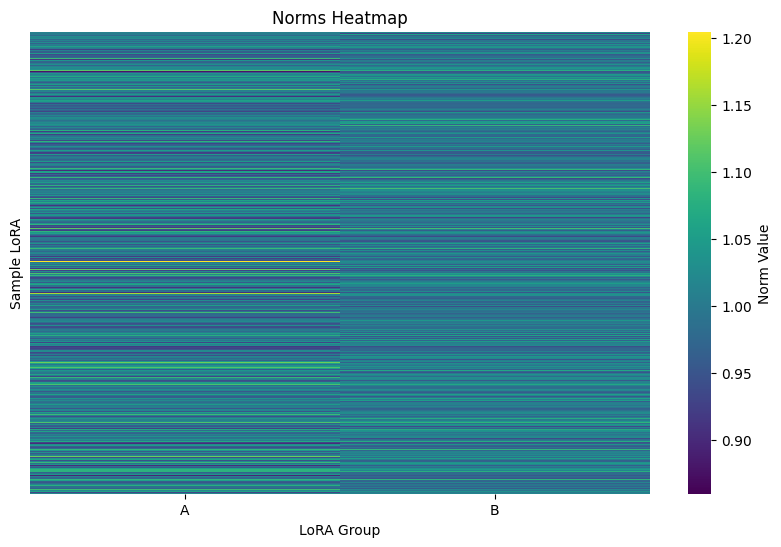

In [49]:
group_indices = get_group_indices(dim_df, ["lora_ab"])
get_heatmap_grouped(group_indices)

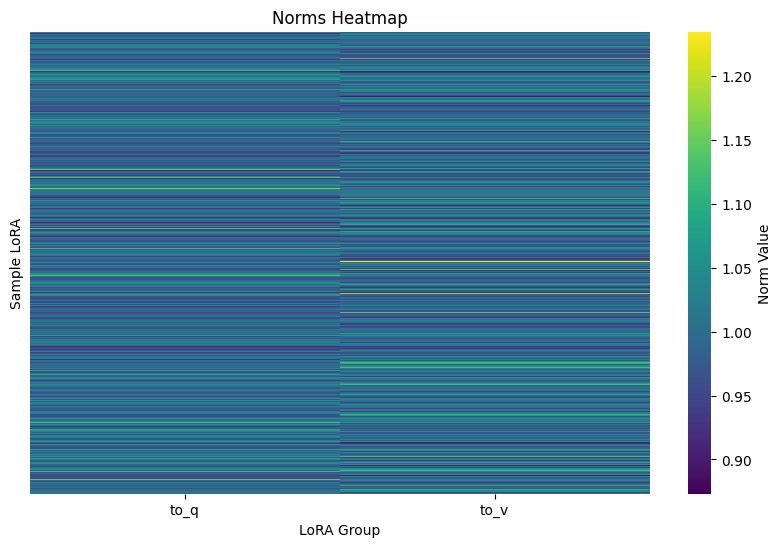

In [50]:
group_indices = get_group_indices(dim_df, ["attn_proj"])
get_heatmap_grouped(group_indices)

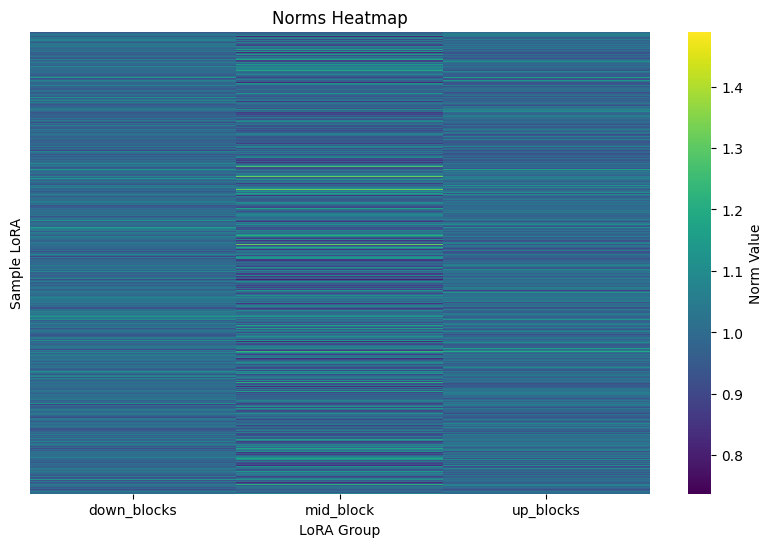

In [51]:
group_indices = get_group_indices(dim_df, ["block_type"])
get_heatmap_grouped(group_indices)

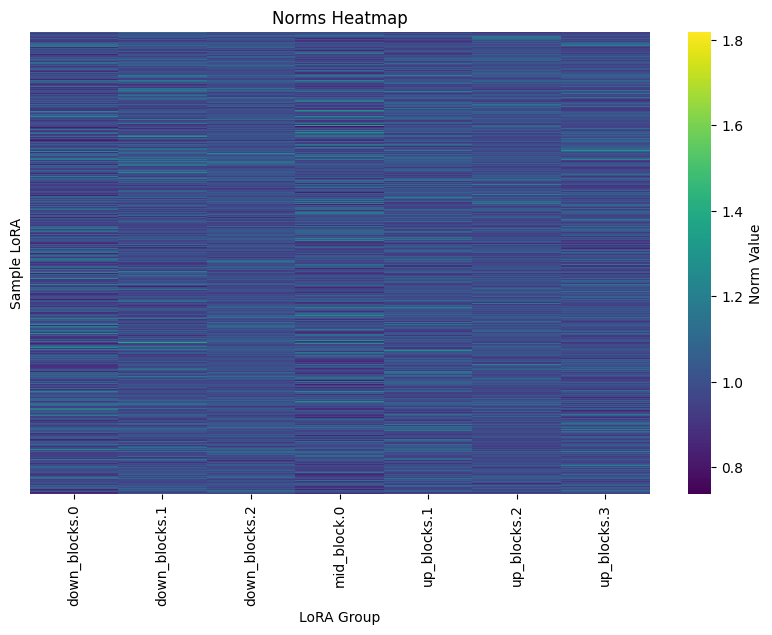

In [52]:
group_indices = get_group_indices(dim_df, ["block_type","block_number"])
get_heatmap_grouped(group_indices)

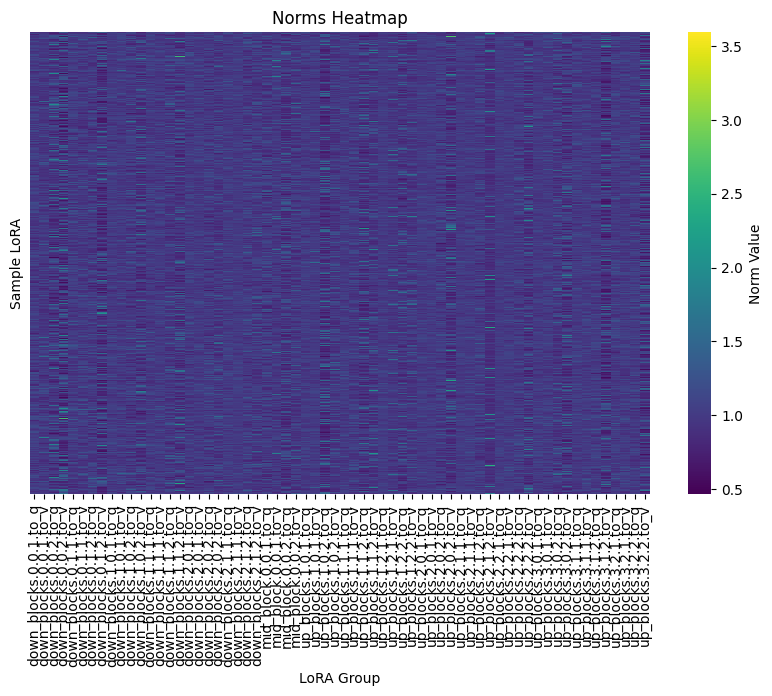

In [53]:
group_indices = get_group_indices(dim_df, ["block_type","block_number","attentions_number", "attn_number", "attn_proj"])
get_heatmap_grouped(group_indices)

### If rescaling

In [9]:
min_val = weights.min()
max_val = weights.max()
# outmap = (weights - outmap_min) / (outmap_max - outmap_min)

In [ ]:
min_val, max_val

In [56]:
mean = weights.mean(dim=0, keepdim=True)
std = weights.std(dim=0, keepdim=True)
mean.shape, std.shape

(torch.Size([1, 99648]), torch.Size([1, 99648]))

In [57]:
# weights.sub_(min_val).div_(max_val - min_val).mul_(2).sub_(1)
weights.sub_(mean).div_(std) 

tensor([[ 0.1462,  0.5698, -1.1664,  ...,  0.3946, -1.8906,  0.0864],
        [ 2.5043,  2.1175, -0.2303,  ...,  0.3032, -0.5183, -1.9873],
        [ 0.8336,  2.3968, -1.2130,  ...,  1.3471, -0.1655,  0.6907],
        ...,
        [-0.7140, -0.8955,  0.7735,  ..., -0.4987, -1.7754,  0.7562],
        [-2.0221, -2.5222,  0.2395,  ..., -0.9113,  0.6542, -0.0689],
        [ 0.6755, -0.1706, -1.3312,  ..., -1.1764, -0.1161,  0.6652]],
       device='cuda:0')

In [73]:
path

'weights2weights/weights_datasets'

In [75]:
if not os.path.exists(f"{path}/normalization"):
    os.makedirs(f"{path}/normalization")
torch.save(mean, f"{path}/normalization/mean.pt")
torch.save(std, f"{path}/normalization/std.pt")

In [58]:
name = "rescaled" # "single"

### Save

In [61]:
for i, row in enumerate(weights):
    filename = f"{path}/{name}/{filenames[i]}.pt"
    torch.save(row.clone(), filename) 

In [62]:
import os

data_dir =  f"{path}/{name}/"
file_list = sorted(os.listdir(data_dir)) 
len(file_list)

64974

In [63]:
def data_generator():
    for filename in file_list:
        file_path = os.path.join(data_dir, filename)
        tensor = torch.load(file_path)  # Load tensor lazily
        yield {"filename": filename, "data": tensor.cpu().numpy()}  # Convert tensor to NumPy
        
dataset = Dataset.from_generator(data_generator, cache_dir=f"{path}/.cache")
dataset.save_to_disk(f"{path}/full_rescaled")

Loading dataset shards:   0%|          | 0/33 [00:00<?, ?it/s]

Saving the dataset (0/52 shards):   0%|          | 0/64974 [00:00<?, ? examples/s]

In [64]:
dataset.data

ConcatenationTable
filename: string
data: list<item: float>
  child 0, item: float
----
filename: [["000005.pt","000007.pt","000008.pt","000010.pt","000014.pt",...,"003075.pt","003077.pt","003079.pt","003080.pt","003083.pt"],["003084.pt","003086.pt","003089.pt","003090.pt","003091.pt",...,"006151.pt","006163.pt","006168.pt","006169.pt","006170.pt"],...,["196424.pt","196427.pt","196429.pt","196436.pt","196439.pt",...,"199532.pt","199536.pt","199538.pt","199540.pt","199542.pt"],["199550.pt","199554.pt","199556.pt","199563.pt","199565.pt",...,"202586.pt","202594.pt","202595.pt","202598.pt","202599.pt"]]
data: [[[-1.8746604,0.84847146,0.20085122,0.22724421,-2.068874,...,0.73603505,-0.19985156,-0.26428276,0.0040533966,0.07210073],[-0.9661519,1.4343969,0.9316347,0.9592373,-1.9292203,...,0.87464154,-0.21917571,-0.276998,0.20898321,-0.14389692],...,[-1.5428207,0.61325324,1.8773752,0.39996728,-2.8312006,...,0.9374626,-0.3358279,-0.47134152,0.22772548,0.05054191],[-2.414712,0.43791538,2.0573425,